<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/Unet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf


In [ ]:
def batch_ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
batch_mse = tf.keras.metrics.RootMeanSquaredError(name='batch_mse', dtype=None)
def batch_psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))


In [ ]:
load_data_DIR = "/content/drive/My Drive/CSE499N/Single Coil 4x/"
load_data_DIR

'/content/drive/My Drive/CSE499N/Single Coil 4x/'

In [ ]:
x_train = np.load("{}/x_train.npy".format(load_data_DIR))
y_train = np.load("{}/y_train.npy".format(load_data_DIR))

x_train.shape, y_train.shape

((3520, 320, 320, 1), (3520, 320, 320, 1))

In [ ]:
model = None

def unet():
    inputs = Input((320, 320, 1))
    #s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=[batch_ssim,batch_mse, batch_psnr])
    return model

In [ ]:
model= unet()

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 320, 320, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [ ]:
h = model.fit(x_train, y_train, validation_split=0.1, batch_size=32, epochs=5)

Epoch 1/5
99/99 [==============================] - 5124s 52s/step - loss: 0.0145 - batch_ssim: 0.9488 - batch_mse: 0.0802 - batch_psnr: 79.0293 - val_loss: 6.5684e-05 - val_batch_ssim: 0.9999 - val_batch_mse: 1.0167e-04 - val_batch_psnr: 83.5980
Epoch 2/5
99/99 [==============================] - 5110s 52s/step - loss: 4.2723e-05 - batch_ssim: 1.0000 - batch_mse: 1.9959e-04 - batch_psnr: 87.3663 - val_loss: 6.5684e-05 - val_batch_ssim: 0.9999 - val_batch_mse: 1.0167e-04 - val_batch_psnr: 83.5980
Epoch 3/5
99/99 [==============================] - 5101s 52s/step - loss: 4.2730e-05 - batch_ssim: 1.0000 - batch_mse: 2.0931e-04 - batch_psnr: 87.3321 - val_loss: 6.5684e-05 - val_batch_ssim: 0.9999 - val_batch_mse: 1.0167e-04 - val_batch_psnr: 83.5980
Epoch 4/5
99/99 [==============================] - 5126s 52s/step - loss: 4.2703e-05 - batch_ssim: 1.0000 - batch_mse: 1.4826e-04 - batch_psnr: 87.4763 - val_loss: 6.5684e-05 - val_batch_ssim: 0.9999 - val_batch_mse: 1.0167e-04 - val_batch_psnr: 

In [ ]:
model.save("/content/drive/My Drive/CSE499N/unet_v1.h5")
print("done ")

done 


In [ ]:
h.model.save("/content/drive/My Drive/CSE499N/unet_v2.h5")
print("done")

done


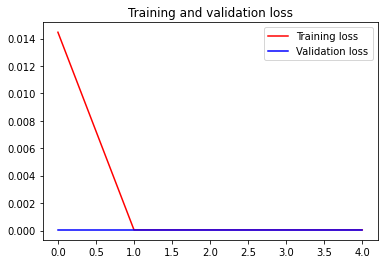

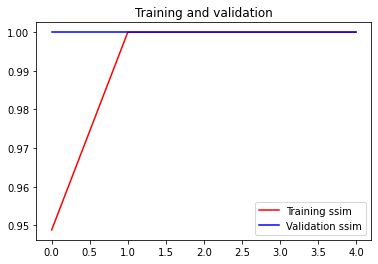

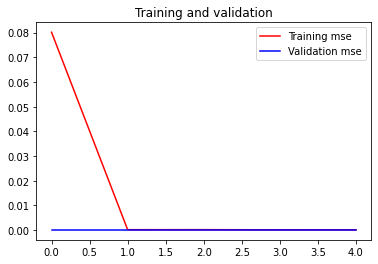

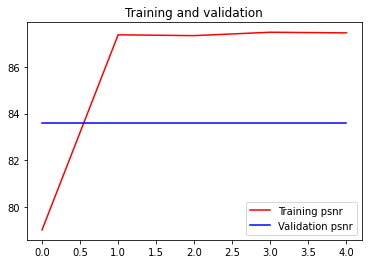

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = h.history['loss']
val_loss = h.history['val_loss']

ssim = h.history['batch_ssim']
val_ssim = h.history['val_batch_ssim']


mse = h.history['batch_mse']
val_mse = h.history['val_batch_mse']

psnr = h.history['batch_psnr']
val_psnr = h.history['val_batch_psnr']

epochs = range(len(loss))


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, ssim, 'r', label='Training ssim')
plt.plot(epochs, val_ssim, 'b', label='Validation ssim')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, mse, 'r', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, psnr, 'r', label='Training psnr')
plt.plot(epochs, val_psnr, 'b', label='Validation psnr')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()